In [15]:
path = '/Users/arjunbhadran/Desktop/Sem_6/ml/pit stop prediciton'
data_path = '/Users/arjunbhadran/Desktop/Sem_6/ml/pit stop prediciton/cache/'

In [16]:
import os
os.chdir(path)
import pandas as pd
import logging
import json
import pickle
import requests
import numpy as np
import fastf1
import matplotlib.pyplot as plt
import pickle
from fastf1.core import DataNotLoadedError

fastf1.Cache.enable_cache(data_path)

Creating functions to return data in a structure that we want. 

In [17]:
def get_lap_data(session, schedule, evnt, ses, EventDate):
    '''get lap data from a session and
       retun as a dataframe
    '''
    if len(session.laps)==0:
        return []
    lap = session.laps.to_dict()
    lap = pd.DataFrame.from_dict(lap)
    lap['RoundNumber'] = schedule['RoundNumber'][schedule['EventName']==evnt].values[0]
    lap['EventName'] = evnt
    lap['country'] = schedule['Country'][schedule['EventName']==evnt].values[0]
    lap['session'] = ses
    lap['EventDate'] = schedule[EventDate][schedule['EventName']==evnt].values[0]
    return lap

def get_weather_data(session, schedule, evnt, ses,EventDate): 
    '''get weather data from a session and
       retun as a dataframe
    '''
    if len(session.weather_data)==0:
        return []
    weather = session.weather_data.to_dict()
    weather = pd.DataFrame.from_dict(weather)
    weather['RoundNumber'] = schedule['RoundNumber'][schedule['EventName']==evnt].values[0]
    weather['EventName'] = evnt
    weather['country'] = schedule['Country'][schedule['EventName']==evnt].values[0]
    weather['session'] = ses
    weather['EventDate'] = schedule[EventDate][schedule['EventName']==evnt].values[0]
    return weather

def get_car_data(session, schedule, evnt, ses,EventDate):
    '''get car_data from a session and
       retun as a dataframe
    '''
    if len(session.car_data)==0:
        return []
    session.weather_data
    for ii in session.car_data:
        car_data = session.car_data[ii].to_dict()
        car_data = pd.DataFrame.from_dict(car_data)
        car_data['driver'] = ii
    car_data['RoundNumber'] = schedule['RoundNumber'][schedule['EventName']==evnt].values[0]
    car_data['EventName'] = evnt
    car_data['country'] = schedule['Country'][schedule['EventName']==evnt].values[0]
    car_data['session'] = ses
    car_data['EventDate'] = schedule[EventDate][schedule['EventName']==evnt].values[0]
    return car_data

def get_position_data(session, schedule, evnt, ses, EventDate):
    '''get position_data from a session and
       retun as a dataframe
    '''    
    if len(session.pos_data)==0:
        return []
    for ii in session.pos_data:
        position = session.pos_data[ii].to_dict()
        position = pd.DataFrame.from_dict(position)
        position['driver'] = ii
    position['RoundNumber'] = schedule['RoundNumber'][schedule['EventName']==evnt].values[0]
    position['EventName'] = evnt
    position['country'] = schedule['Country'][schedule['EventName']==evnt].values[0]
    position['session'] = ses
    position['EventDate'] = schedule[EventDate][schedule['EventName']==evnt].values[0]
    return position

def get_results(session, schedule, evnt, ses, EventDate):
    '''get results data from a session and
       retun as a dataframe
    '''
    if len(session.results)==0:
        return []
    result = session.results.to_dict()
    result = pd.DataFrame.from_dict(result).reset_index()
    result['RoundNumber'] = schedule['RoundNumber'][schedule['EventName']==evnt].values[0]
    result['EventName'] = evnt
    result['country'] = schedule['Country'][schedule['EventName']==evnt].values[0]
    result['session'] = ses
    result['EventDate'] = schedule[EventDate][schedule['EventName']==evnt].values[0]
    return result

In [ ]:
# Pulling data and storing it in the data directory

sessionDateMap = {'Race': 'Session5Date',
          'Qualifying': 'Session4Date',
            'FP1': 'Session1Date',
            'FP2': 'Session2Date',
            'FP3': 'Session3Date',
            'S':  'Session4Date',
            'SQ':  'Session4Date'}

for year in [2018, 2019, 2020, 2021]:
    laps = []
    weathers = []
    results = []
    
    sch = fastf1.get_event_schedule(year).to_dict()
    sch = pd.DataFrame.from_dict(sch)
        
    EventName = [s for s in sch['EventName'] if 'Grand' in s]
    
    for event in EventName:
        for session_type in ['FP1','FP2','FP3','S','SQ','Qualifying','Race']:
            
            eventDateColName = sessionDateMap[session_type]
            
            session = None
            
            try:
                session = fastf1.get_session(year, event, session_type) # call fastf1 to extract data
            except:
                print('Session: {} does not exist {}.'.format(session_type, event))
                session = None
            if session is not None:
                try:
                    session.load()
                except:
                    print('Session: ' + session_type + ' does not provide usable data {}.'.format(event))
                    session = None
            
            # if the session exists, extract all data with auxiliary functions from the above cells
            if session is not None:
                try:
                    ## get lap data for a session
                    laps.append(get_lap_data(session, sch, event, 
                                             session_type, eventDateColName))

                    ## get weather data for a session
                    weathers.append(get_weather_data(session, sch, event, 
                                                     session_type, eventDateColName))

                    ## get results for a session
                    results.append(get_results(session, sch, event, 
                                               session_type, eventDateColName))
                except DataNotLoadedError:
                    print('Trying to access data that isn\'t loaded yet')
                    continue


    ## save all extracted session data in a year           
    file = open('{}{}_{}.pkl'.format(data_path, 'laps', year), 'wb')
    pickle.dump(laps,file)
    file = open('{}{}_{}.pkl'.format(data_path, 'weathers', year), 'wb')
    pickle.dump(weathers,file)
    file = open('{}{}_{}.pkl'.format(data_path, 'results', year), 'wb')
    pickle.dump(results,file)

Concatenating all relevant pickle files from each type, and save them into a single pickle for each one of the types.

In [21]:
def concat_data_and_save(data_source, data_path):
    '''
    e.g. data_source is weather
    1. finds all pkl files in the data_path folder
    2. concat all
    3. saves the in 'data_source'.pickle
    '''
    data = []
    files = os.listdir(data_path)
    file = [x for x in files if x.endswith('.pkl') if data_source in x]
    
    for fl in file:
        print(fl)
        file = open('{}{}'.format(data_path, fl), 'rb')
        data.extend(pickle.load(file))
    data = pd.concat(data, axis=0)

    file = open('{}{}_data.pickle'.format(data_path, data_source), 'wb')
    pickle.dump(data,file)
    return

At this point, we've finished the data extraction process.

In [24]:
concat_data_and_save('cacheweathers', data_path)
concat_data_and_save('cachelaps', data_path)
concat_data_and_save('cacheresults', data_path)

cacheweathers_2019.pkl
cacheweathers_2018.pkl
cacheweathers_2020.pkl
cacheweathers_2021.pkl
cachelaps_2018.pkl
cachelaps_2019.pkl
cachelaps_2021.pkl
cachelaps_2020.pkl
cacheresults_2021.pkl
cacheresults_2020.pkl
cacheresults_2018.pkl
cacheresults_2019.pkl


In [18]:
import os
os.chdir(path)
import pandas as pd
import logging
import json
import pickle
import requests
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [19]:
file = open('{}{}'.format(data_path, 'cacheweathers_data.pickle'),'rb')
df_weather = pickle.load(file)
# adding eventYear to the dataset
#print(pd.to_datetime(df_weather['EventDate'], utc=True).dt.year)
df_weather['eventYear'] = pd.to_datetime(df_weather['EventDate'], utc=True).dt.year # get the year

df_weather.head(2)

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,RoundNumber,EventName,country,session,EventDate,eventYear
0,0 days 00:00:43.298000,20.7,50.4,1019.7,False,31.6,156,1.5,1,Australian Grand Prix,Australia,FP1,2019-03-15 12:00:00+11:00,2019
1,0 days 00:01:43.309000,20.7,49.6,1019.7,False,32.2,151,3.4,1,Australian Grand Prix,Australia,FP1,2019-03-15 12:00:00+11:00,2019


In [20]:
df_weather.columns

Index(['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed', 'RoundNumber', 'EventName', 'country',
       'session', 'EventDate', 'eventYear'],
      dtype='object')

In [21]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df_weather['Rainfall']=le.fit_transform(df_weather['Rainfall'])

In [22]:
# Filter the DataFrame for 'Race' sessions
race_sessions = df_weather[df_weather['session'] == 'Race']

# Select only numeric columns for mean calculation. Assuming 'EventName', 'session', and 'EventDate' are not numeric and are used for grouping.
numeric_cols = race_sessions.select_dtypes(include=['number'])

# Perform the grouping and mean calculation on numeric columns only
avg_weather = numeric_cols.groupby([race_sessions['EventName'], race_sessions['session'], race_sessions['EventDate'],race_sessions['Rainfall']]).mean().reset_index().sort_values(['EventName'])

avg_weather.head(5)


,EventName,session,EventDate,Rainfall,Time,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,WindSpeed,RoundNumber,eventYear
0,70th Anniversary Grand Prix,Race,2020-08-09 14:10:00+01:00,False,0 days 00:58:00.193698275,25.287069,58.556034,1000.950862,43.227586,71.931034,2.236207,5.0,2020.0
1,Abu Dhabi Grand Prix,Race,2018-11-25 17:10:00+04:00,False,0 days 01:07:23.679664122,31.308397,45.166412,1013.095420,33.396183,239.870229,2.102290,21.0,2018.0
2,Abu Dhabi Grand Prix,Race,2018-11-25 17:10:00+04:00,True,0 days 01:27:47.546000,30.516667,51.366667,1013.466667,31.616667,269.666667,3.500000,21.0,2018.0
3,Abu Dhabi Grand Prix,Race,2019-12-01 17:10:00+04:00,False,0 days 01:06:46.487676691,26.018045,64.471429,1015.383459,29.566165,221.097744,1.264662,21.0,2019.0
4,Abu Dhabi Grand Prix,Race,2020-12-13 17:10:00+04:00,False,0 days 01:07:26.646866666,23.121481,55.446667,1015.847407,27.980000,258.244444,2.504444,17.0,2020.0


<font size="5">Exploratory Data Analysis</font>

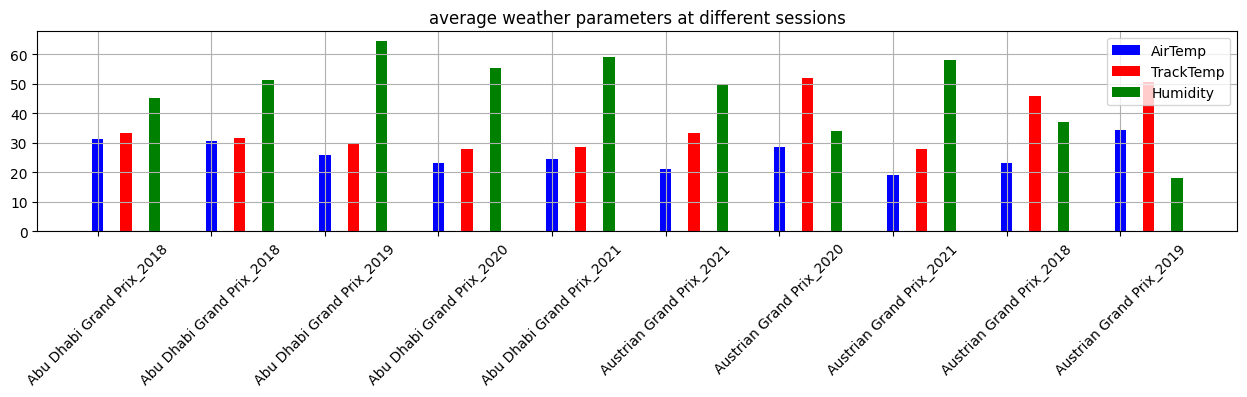

In [23]:
# Visualizeing track temperature, air temperature and humidity % since
# tire life/performance depends on the track temperature
def plot_weather(d_f):

    fig = plt.figure(figsize=(12,2))
    ax = fig.add_axes([0,0,1,1])
    labels = [d_f.loc[x,['EventName']].values[0] +'_'+ 
              str(pd.DatetimeIndex(d_f.loc[x,['EventDate']]).year.values[0]) 
              for x in range(len(d_f))]
    x = np.arange(len(labels) )
    ax.bar(x + 0.00, d_f['AirTemp'], color='b', width=0.10)
    ax.bar(x + 0.25, d_f['TrackTemp'], color='r', width=0.10)
    ax.bar(x + 0.50, d_f['Humidity'], color='g', width=0.10)
    ax.set_xticks(x, labels, rotation=45, fontsize =10)
    ax.legend(['AirTemp','TrackTemp','Humidity'])
    ax.grid()
    plt.title('average weather parameters at different sessions')
    plt.show()
    return


plot_weather(avg_weather[(avg_weather['EventName']=='Austrian Grand Prix') | 
    (avg_weather['EventName']=='Abu Dhabi Grand Prix')].reset_index())

<font size="5">**Race Results Data**</font>

In [24]:
file = open('{}{}'.format(data_path, 'cacheresults_data.pickle'),'rb')
df_res = pickle.load(file)
df_res['TeamName'].unique()

array(['AlphaTauri', 'Red Bull Racing', 'Alpine', 'Ferrari',
       'Aston Martin', 'McLaren', 'Mercedes', 'Haas F1 Team', 'Williams',
       'Alfa Romeo Racing', 'Alfa Romeo', 'Alpine F1 Team',
       'Racing Point', 'Renault', 'None', 'Toro Rosso', 'Force India',
       'Sauber'], dtype=object)

<font size="4">**Taking data for Mercedes**</font>

In [25]:
df_res['eventYear'] = pd.to_datetime(df_res['EventDate'], utc=True).dt.year
df_res['Q1Sec'] = df_res['Q1']/np.timedelta64(1, 's')
df_res['Q2Sec'] = df_res['Q2']/np.timedelta64(1, 's')
df_res['Q3Sec'] = df_res['Q3']/np.timedelta64(1, 's')
df_res['TimeSec'] = df_res['Time']/np.timedelta64(1, 's')

df_res = df_res[df_res['TeamName']=='Mercedes'] 

#only taking race and qualifier data
df_res = df_res[(df_res['session']=='Race') | (df_res['session']=='Qualifying')]
print('df_res size is: ', df_res.shape)
print('-'*100,'\n')

df_res= df_res[['Position','GridPosition','FullName','Q1Sec','Q2Sec','Q3Sec','RoundNumber','Abbreviation',
                'EventName','eventYear','session','Time','TimeSec','TeamName', 'EventDate']]

# Display round number 5, sort by position and year
df_res[df_res['RoundNumber']==5].sort_values(['Position','eventYear','Abbreviation'], ascending=False)

df_res size is:  (324, 32)
---------------------------------------------------------------------------------------------------- 



,Position,GridPosition,FullName,Q1Sec,Q2Sec,Q3Sec,RoundNumber,Abbreviation,EventName,eventYear,session,Time,TimeSec,TeamName,EventDate
18,19.0,3.0,Valtteri Bottas,NaN,NaN,NaN,5,BOT,Monaco Grand Prix,2021,Race,NaT,NaN,Mercedes,2021-05-23 15:00:00+02:00
6,7.0,NaN,Lewis Hamilton,71.622,71.116,71.095,5,HAM,Monaco Grand Prix,2021,Qualifying,NaT,NaN,Mercedes,2021-05-22 15:00:00+02:00
6,7.0,7.0,Lewis Hamilton,NaN,NaN,NaN,5,HAM,Monaco Grand Prix,2021,Race,0 days 00:01:08.231000,68.231,Mercedes,2021-05-23 15:00:00+02:00
2,3.0,NaN,Valtteri Bottas,70.938,70.695,70.601,5,BOT,Monaco Grand Prix,2021,Qualifying,NaT,NaN,Mercedes,2021-05-22 15:00:00+02:00
2,3.0,1.0,Valtteri Bottas,NaN,NaN,NaN,5,BOT,70th Anniversary Grand Prix,2020,Race,0 days 00:00:19.231000,19.231,Mercedes,2020-08-09 14:10:00+01:00
1,2.0,NaN,Lewis Hamilton,86.818,86.266,85.217,5,HAM,70th Anniversary Grand Prix,2020,Qualifying,NaT,NaN,Mercedes,2020-08-08 14:00:00+01:00
1,2.0,2.0,Lewis Hamilton,NaN,NaN,NaN,5,HAM,70th Anniversary Grand Prix,2020,Race,0 days 00:00:11.326000,11.326,Mercedes,2020-08-09 14:10:00+01:00
1,2.0,NaN,Lewis Hamilton,77.292,76.038,76.040,5,HAM,Spanish Grand Prix,2019,Qualifying,NaT,NaN,Mercedes,2019-05-11 15:00:00+02:00
1,2.0,1.0,Valtteri Bottas,NaN,NaN,NaN,5,BOT,Spanish Grand Prix,2019,Race,0 days 00:00:04.074000,4.074,Mercedes,2019-05-12 15:10:00+02:00
1,2.0,NaN,Valtteri Bottas,77.674,77.111,76.213,5,BOT,Spanish Grand Prix,2018,Qualifying,NaT,NaN,Mercedes,2018-05-12 15:00:00+02:00


<font size="5">**Lap Data**</font>

In [26]:
file = open('{}{}'.format(data_path, 'cachelaps_data.pickle'),'rb')

# dropping all the unncecsary columns
drop_cols = ['Sector1Time','Sector2Time','Sector3Time',
             'Sector1SessionTime','Sector2SessionTime','Sector3SessionTime',
            'SpeedI1','SpeedI2','SpeedFL', 'IsAccurate']

# create dataframe, drop columns, drop row numbers as well
df_laps = pickle.load(file).drop(drop_cols, axis=1).reset_index(drop=True)

df_laps['eventYear'] = pd.to_datetime(df_laps['EventDate'], utc=True).dt.year
df_laps['lapTimeSec'] = df_laps['LapTime']/np.timedelta64(1, 's')

df_laps = df_laps[df_laps['Team']=='Mercedes']
df_laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,SpeedST,IsPersonalBest,...,Deleted,DeletedReason,FastF1Generated,RoundNumber,EventName,country,session,EventDate,eventYear,lapTimeSec
300,0 days 00:27:52.095000,HAM,44,NaT,1.0,1.0,0 days 00:10:02.763000,0 days 00:12:05.162000,193.0,False,...,False,,False,1,Australian Grand Prix,Australia,FP1,2018-03-23 12:00:00+11:00,2018,NaN
301,0 days 00:29:53.136000,HAM,44,0 days 00:02:01.041000,2.0,2.0,0 days 00:27:55.309000,NaT,187.0,False,...,False,,False,1,Australian Grand Prix,Australia,FP1,2018-03-23 12:00:00+11:00,2018,121.041
302,0 days 00:31:29.658000,HAM,44,0 days 00:01:36.522000,3.0,2.0,NaT,NaT,284.0,True,...,False,,False,1,Australian Grand Prix,Australia,FP1,2018-03-23 12:00:00+11:00,2018,96.522
303,0 days 00:32:55.352000,HAM,44,0 days 00:01:25.694000,4.0,2.0,NaT,NaT,306.0,True,...,False,,False,1,Australian Grand Prix,Australia,FP1,2018-03-23 12:00:00+11:00,2018,85.694
304,0 days 00:34:51.675000,HAM,44,0 days 00:01:56.323000,5.0,2.0,NaT,NaT,252.0,False,...,False,,False,1,Australian Grand Prix,Australia,FP1,2018-03-23 12:00:00+11:00,2018,116.323


In [27]:
df_laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound',
       'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate',
       'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'RoundNumber', 'EventName', 'country', 'session',
       'EventDate', 'eventYear', 'lapTimeSec'],
      dtype='object')

<font size="4">Plotting Pair wise relationships in Mercedes Lap data</font>

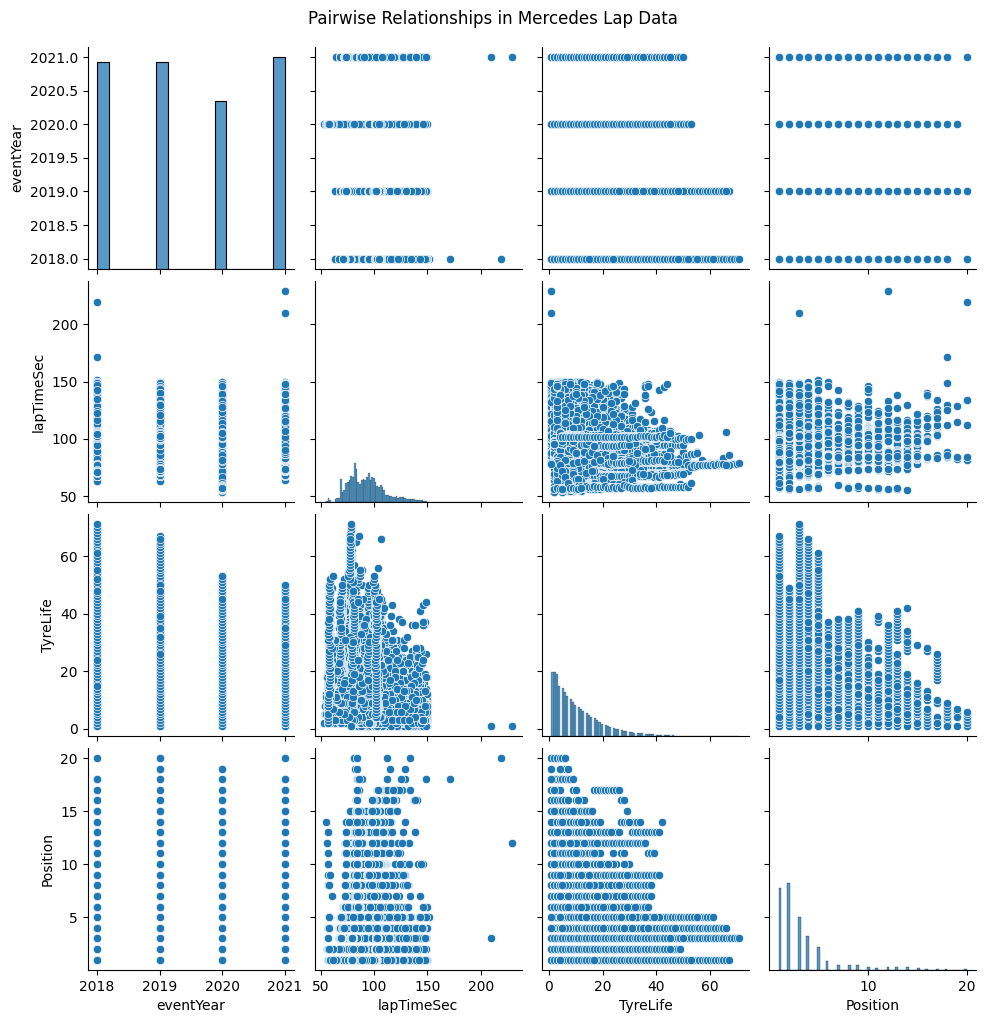

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting a subset of columns for the pair plot to avoid overcrowding the plot
columns_of_interest = ['eventYear', 'lapTimeSec','Compound','TyreLife','TrackStatus', 'Position']

sns.pairplot(df_laps[columns_of_interest])

plt.suptitle('Pairwise Relationships in Mercedes Lap Data', y=1.02)
plt.show()


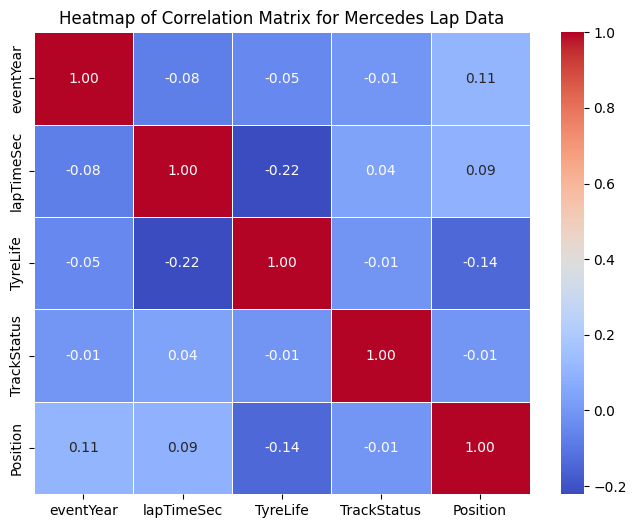

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting a subset of columns for correlation analysis to avoid overcrowding the heatmap
columns_of_interest = ['eventYear', 'lapTimeSec','TyreLife','TrackStatus', 'Position']

# Correlation matrix for the selected columns
corr_matrix = df_laps[columns_of_interest].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Correlation Matrix for Mercedes Lap Data')
plt.show()

<font size="5">**Merging the Data**</font>

Dropping non-race and non-qualifying rows from results data and keeping the following columns: 'Position','FullName','Q1Sec','Q2Sec','Q3Sec','RoundNumber','EventName','eventYear','session','TimeSec'

In [30]:
file = open(data_path+'cacheresults_data.pickle','rb')
df_res = pickle.load(file)

#converting time detla to seconds
df_res['eventYear'] = pd.to_datetime(df_res['EventDate'], utc=True).dt.year
df_res['Q1Sec'] = df_res['Q1']/np.timedelta64(1, 's')
df_res['Q2Sec'] = df_res['Q2']/np.timedelta64(1, 's')
df_res['Q3Sec'] = df_res['Q3']/np.timedelta64(1, 's')
df_res['TimeSec'] = df_res['Time']/np.timedelta64(1, 's')


## keep only race and qualifying data
df_res = df_res[(df_res['session']=='Race') | (df_res['session']=='Qualifying')]
print('df_res size is: ', df_res.shape,'\n')
print()

df_res= df_res[['Position','GridPosition','FullName','Q1Sec','Q2Sec','Q3Sec','RoundNumber','Abbreviation',
                'EventName','eventYear','session','Time','TimeSec','TeamName', 'EventDate']]

df_res size is:  (3240, 32) 




Now,loading lap data and converting times to useable format

In [31]:
file = open(data_path+'cachelaps_data.pickle','rb')

drop_cols = ['Sector1Time','Sector2Time','Sector3Time',
             'Sector1SessionTime','Sector2SessionTime','Sector3SessionTime',
            'SpeedI1','SpeedI2','SpeedFL', 'IsAccurate']

df_laps = pickle.load(file).drop(drop_cols,axis=1).reset_index(drop=True)

df_laps['eventYear'] = pd.to_datetime(df_laps['EventDate'], utc=True).dt.year
df_laps['lapTimeSec'] = df_laps['LapTime']/np.timedelta64(1, 's')


Now aligning weather data since it is accessible on a session basis, but its timestamp doesn't synchronize with laps data.

In [32]:
file = open(data_path+'cacheweathers_data.pickle','rb')
df_weather = pickle.load(file)
df_weather['eventYear'] = pd.to_datetime(df_weather['EventDate'], utc=True).dt.year

<font size="4">Now merging weather and lap data</font>

In [33]:
## Weather and Laps data are not time-aligned and each have their own 

df_weather = df_weather.sort_values( ['EventName','eventYear','session', 'Time']).reset_index(drop=True)
df_laps = df_laps.sort_values( ['EventName','eventYear','session','Team','Driver', 'Time']).reset_index(drop=True)

LapsColumns = ['EventName','eventYear','Team','session','Driver',
               'Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime',
       'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife',
       'FreshTyre', 'LapStartTime', 'TrackStatus',
       'LapStartDate',  'country', 'EventDate','lapTimeSec']

In [34]:
%%time

import warnings
warnings.filterwarnings("ignore")

# grouping lap data by event, session... etc and then go to weather data and extract relevant weather information.
# since time doesn't quite match, we find the closest possible time between both tables.
# merge_asof allows us to find the nearest time between the two tables and combine them.
def func_merger_lap_weather(d_f):
    '''
    func_merger_lap_weather method merges weather and laps data
    it returns all columns after merge
    '''    
    
    d_f = d_f.sort_values('Time').reset_index(drop=True)
    
    EventName = np.unique(d_f['EventName'])[0]
    session = np.unique(d_f['session'])[0]
    eventYear = np.unique(d_f['eventYear'])[0]
    Driver = np.unique(d_f['Driver'])
    
    sub_weather = df_weather[(df_weather['EventName']==EventName) &
                            (df_weather['session']==session) &
                            (df_weather['eventYear']==eventYear) ].sort_values('Time').reset_index(drop=True)
    
    sub_result = df_res[(df_weather['EventName']==EventName) &
                            (df_weather['session']==session) &
                            (df_weather['eventYear']==eventYear) ].sort_values('Time').reset_index(drop=True)
    
    d_f_merged = pd.merge_asof(d_f, sub_weather, 
                          on="Time", direction='nearest',
                         suffixes=('', '_drop'))
    d_f_merged.drop([col for col in d_f_merged.columns if 'drop' in col], axis=1, inplace=True)
    
#     print(d_f.shape,Driver, len(d_f_merged), EventName , eventYear, np.unique(d_f['Team']), 
#           session, len(df_weather))
    weather_cols = ['WindSpeed', 'AirTemp','Humidity', 'Pressure','TrackTemp','Rainfall','WindDirection']
    laps_cols = ['Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'RoundNumber',
       'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife','FreshTyre', 'LapStartTime', 'TrackStatus',
       'LapStartDate',  'country', 'EventDate','lapTimeSec']
    laps_cols.extend(weather_cols) 
    
    return  d_f_merged[laps_cols]

df_lapWeather = df_laps.groupby(['EventName', 'eventYear','Team','session','Driver'])[LapsColumns].apply(func_merger_lap_weather).reset_index()

CPU times: user 52.5 s, sys: 164 ms, total: 52.7 s
Wall time: 53.1 s


In [35]:
df_lapWeather.columns

Index(['EventName', 'eventYear', 'Team', 'session', 'Driver', 'level_5',
       'Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime',
       'RoundNumber', 'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound',
       'TyreLife', 'FreshTyre', 'LapStartTime', 'TrackStatus', 'LapStartDate',
       'country', 'EventDate', 'lapTimeSec', 'WindSpeed', 'AirTemp',
       'Humidity', 'Pressure', 'TrackTemp', 'Rainfall', 'WindDirection'],
      dtype='object')

<font size="4">**Merging the resulting weather-lap data and Grid position from results**</font>

In [36]:
'''
add grid position and summarize lap data (summarization = extract meaningful features up until the race).
Anything before the race is the feature for upcoming races.
To do that, we take the best qualifying time, grid position, position... and convert to a numerical value
'''

lapWeatherCols = df_lapWeather.columns

def Features_PerTyre_PreRace_PerDriver(sub_df):
    
    bestTime=sessionName=meanAirTemp=meanTrackTemp=meanHumid=bestLapTimeSession=GridPosition=Position=TyreLife=Rainfall=np.nan  
    
    # get number of unique values for each of these variables
    raceStintsNums = np.unique(sub_df['Stint'])[0]
    raceTyresComps = np.unique(sub_df['Compound'])
    Driver = np.unique(sub_df['Driver'])[0]
    eventYear = np.unique(sub_df['eventYear'])[0]
    EventName = np.unique(sub_df['EventName'])[0]
    RoundNumber =  np.unique(sub_df['RoundNumber'])[0]
    

    # get mean values for these variables
    meanAirTemp = np.nanmean(sub_df['AirTemp'])
    meanTrackTemp = np.nanmean(sub_df['TrackTemp'])
    meanHumid = np.nanmean(sub_df['Humidity'])
    Rainfall = np.nanmean(sub_df['Rainfall'])
    
    GridPosition = df_res['GridPosition'][
                          (df_res['EventName']==EventName)&
                          (df_res['eventYear']==eventYear)&
                          (df_res['Abbreviation']==Driver)&
                          (df_res['RoundNumber']==RoundNumber)&
                          (df_res['session']=='Race')]

    Position = df_res['Position'][
                          (df_res['EventName']==EventName)&
                          (df_res['eventYear']==eventYear)&
                          (df_res['Abbreviation']==Driver)&
                          (df_res['RoundNumber']==RoundNumber)&
                          (df_res['session']=='Race')]
    if len(GridPosition): 
        GridPosition=GridPosition.values[0]
    if len(Position): 
        Position=Position.values[0]
        
    StintLen = []
    StintLen = len(sub_df)

    
    TyreAge = np.min(sub_df['TyreLife'])
    lapNumberAtBeginingOfStint = np.min(sub_df['LapNumber'])
    
    d_f = df_lapWeather[(df_lapWeather['EventName']==EventName)&
                        (df_lapWeather['eventYear']==eventYear)&
                        (df_lapWeather['Driver']==Driver)&
                        (df_lapWeather['RoundNumber']==RoundNumber)&
                        (df_lapWeather['session']=='Qualifying')&
                        (df_lapWeather['Compound']!='raceTyresComps')]
    
    if len(d_f)>0:
        
        bestTime = np.min(d_f['lapTimeSec'])

        if ~np.isnan(bestTime):
            sessionName = np.unique(d_f['session'][d_f['lapTimeSec']==bestTime])[0]
         

    return pd.Series(
        data = [bestTime, sessionName, meanAirTemp, meanTrackTemp, meanHumid, Rainfall,
                             GridPosition,Position, raceStintsNums,TyreAge,lapNumberAtBeginingOfStint, StintLen], 
        index=['bestPreRaceTime','bestLapTimeIsFrom','meanAirTemp','meanTrackTemp','meanHumid','Rainfall', 
                            'GridPosition','Position','raceStintsNums','TyreAge','lapNumberAtBeginingOfStint', 'StintLen'])

In [37]:
%%time

# invoke above function with .apply()
df_agg = df_lapWeather[df_lapWeather['session']=='Race'].groupby(['EventName','RoundNumber','eventYear','Team','Compound',
                                                            'Driver','Stint']).\
                                                            apply(Features_PerTyre_PreRace_PerDriver).reset_index()


CPU times: user 1min 52s, sys: 112 ms, total: 1min 53s
Wall time: 1min 53s


In [38]:
df_agg[df_agg['RoundNumber']==15].reset_index(drop=True).head(2)

,EventName,RoundNumber,eventYear,Team,Compound,Driver,Stint,bestPreRaceTime,bestLapTimeIsFrom,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,Position,raceStintsNums,TyreAge,lapNumberAtBeginingOfStint,StintLen
0,Bahrain Grand Prix,15,2020,Alfa Romeo Racing,HARD,GIO,3.0,89.491,Qualifying,24.739394,26.430303,72.542424,0.0,16.0,16.0,3.0,1.0,21.0,33.0
1,Bahrain Grand Prix,15,2020,Alfa Romeo Racing,HARD,RAI,3.0,89.810,Qualifying,24.778261,26.578261,71.721739,0.0,17.0,15.0,3.0,1.0,18.0,23.0


**Creating the final data file from all the merged data**

In [39]:
df_agg.to_csv('/Users/arjunbhadran/Desktop/Sem_6/ml/pit stop prediciton/semi_final_data.csv', index=False)

Creating a column to identify laps with a large delta-time between two consecutive laps
In normal race conditions, delay-time between two consecutive laps. Large delta time is when the lap is more than or less than the preceding lap time by about 2 seconds.

In [40]:
df_laps['large_delta_time'] = np.nan
df_laps['delta_lapTime'] = np.nan


## create a column for delta_lapTime'
df_laps['delta_lapTime'] = df_laps.groupby(['EventName','eventYear','Driver','session','Stint'])['lapTimeSec'].diff()


## label those who are biger or smaller than +-2
df_laps['large_delta_time']= (df_laps['delta_lapTime']<2) & (df_laps['delta_lapTime']>-2)
print(sum(df_laps['large_delta_time']))

93952


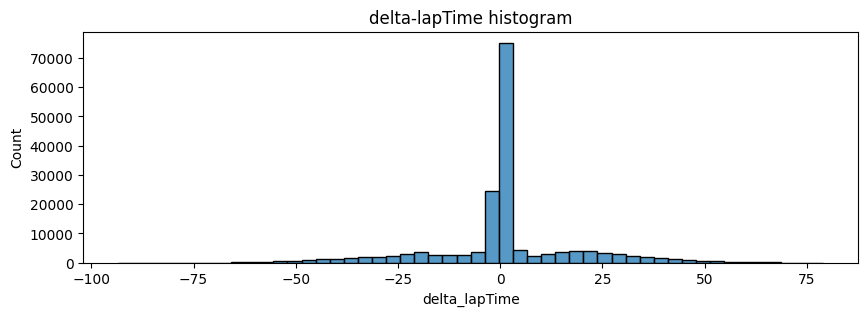

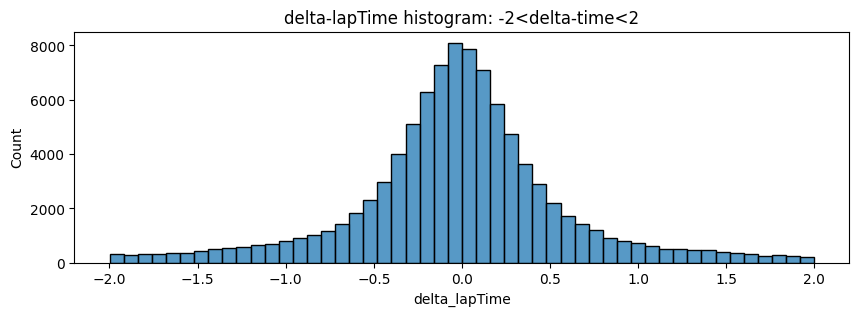

In [41]:
## delta-lapTime histogram without filtering
fig = plt.figure(figsize=(10,3))
sns.histplot(df_laps[df_laps['delta_lapTime'].notnull()],x = 'delta_lapTime', bins=50)
plt.title('delta-lapTime histogram')
plt.show()

fig = plt.figure(figsize=(10,3))
## detal-lapTime histogram with filtering
sns.histplot(df_laps[df_laps['large_delta_time']],x = 'delta_lapTime', bins=50)
plt.title('delta-lapTime histogram: -2<delta-time<2')
plt.show()

# Note: delta-laptime is the delta between two consecutive laps

The central spike near zero suggests that most consecutive lap times are very close to each other, indicating consistent lap times across the dataset. The spread of data points into the negative and positive indicates variations in lap times due to various factors such as pit stops, on-track incidents, or performance inconsistencies.

In [42]:
## calculate Stint length
df_stintLen = df_laps.groupby(['EventName','session', 'Driver', 'Stint']).size().reset_index(name='stintLength')
df = df_laps.merge(df_stintLen, on = ['EventName','session', 'Driver', 'Stint'])
print('-'*100,'\n', 'df_lap length: ',len(df_laps), '   ','df length is: ', len(df), '\n','-'*100)

# Filter only those rows with a stint length > 5 for making calculations with good reliability
## if the stint greater than 5 laps, display remaining rows after this filtering
df = df[(df['stintLength']>=6) & (df['session']=='Race')]
print('-'*100,'\n', 'df_lap length: ',len(df_laps), '   ','df length is: ', len(df), '\n','-'*100)

print('-'*100,'\n', 'Teams are: ',list(np.unique(df['Team']) ), '\n\n',
      'Event Years are: ', list(np.unique(df['eventYear']) ), '\n\n',
      'Drivers are: ', list(np.unique(df['Driver']) ), '\n','-'*100)

---------------------------------------------------------------------------------------------------- 
 df_lap length:  224899     df length is:  223881 
 ----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------- 
 df_lap length:  224899     df length is:  87088 
 ----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------- 
 Teams are:  ['Alfa Romeo Racing', 'AlphaTauri', 'Alpine', 'Aston Martin', 'Ferrari', 'Force India', 'Haas F1 Team', 'McLaren', 'Mercedes', 'Racing Point', 'Red Bull Racing', 'Renault', 'Sauber', 'Toro Rosso', 'Williams'] 

 Event Years are:  [2018, 2019, 2020, 2021] 

 Drivers are:  ['AIT', 'ALB', 'ALO', 'BOT', 'ERI', 'FIT', 'GAS', 'GIO', 'GRO', 'HAM', 'HAR', 'HUL', 'KUB', 'KVY', 'LAT'

<font size="4">**Fuel consumpiton vs laps**</font>

func_fuelLine_sample_points Function calculates the average of the first three lap times after a pit stop (stint), but only for laps where the delta time is not considered large such as within 2 seconds of the previous lap. Returns a series containing this average (mean_val) and the lap number at which the stint began (ind).

func_fuelLine_params Function removes duplicate entries based on the LapNumAfterStint and valueAfterStint columns to ensure unique data points. It uses linear regression (least squares method) to fit a line to the data points representing lap number (LapNumAfterStint) and lap time after the stint (valueAfterStint), to understand how fuel usage impacts lap time across the stint. It calculates the slope (theta[0]) and intercept (theta[1]) of the fitted line, which represent the rate of fuel consumption and the base lap time without fuel weight, respectively. It returns these values as a series with indices fuel_slope and fuel_bias.

In [43]:
%%time
def func_fuelLine_sample_points(d_f):
    '''
    func method return avg of 3 lap-time after Stint and lapNum after Stint
    '''    
    # Preparing X and y data from the given data
    
    x = d_f['LapNumber'][(d_f['large_delta_time']) ].values
    y = d_f['lapTimeSec'][(d_f['large_delta_time']) ].values

    if len(x)<=3: 
        return pd.Series(data = [np.nan, np.nan], index = ['valueAfterStint','LapNumAfterStint'])
    
    # Calculating the parameters using the least square method
    mean_val = np.mean(y[0:3])
    ind = x[0]

    return pd.Series(data = [mean_val, ind], index = ['valueAfterStint','LapNumAfterStint'])


def func_fuelLine_params(d_f):
    '''
    func method fits a line to the to the data points (LapNumber, lapTimeSec) 
    which are collected immediately after each pit
    and returns line slope and bias.
    '''    
    # Preparing X and y data from the given data
    d_f.drop_duplicates(subset=['LapNumAfterStint','valueAfterStint'], keep='first', inplace=True)
    x = d_f['LapNumAfterStint'].values
    y = d_f['valueAfterStint'].values

    if (len(x)<2) | sum(np.isnan(x)) | sum(np.isnan(y)): 
        return pd.Series(data = [np.nan, np.nan], index = ['fuel_slope','fuel_bias'])
    
    # Calculating the parameters using the least square method
    theta = np.polyfit(x, y, 1)
    y_line = theta[1] + theta[0] * x

    return pd.Series(data = [theta[0], theta[1]], index = ['fuel_slope','fuel_bias'])

df_fuel_corr = df.groupby(['EventName','eventYear','session', 'Team','Driver', 'Stint']).apply(func_fuelLine_sample_points).reset_index()
df = df.merge(df_fuel_corr, on= ['EventName','eventYear','session', 'Team','Driver', 'Stint'])

df_theta = df.groupby(['EventName','eventYear','session', 'Team','Driver']).apply(func_fuelLine_params).reset_index() #name=['theta0','theta1']
df = df.merge(df_theta, on= ['EventName','eventYear','session', 'Team','Driver'])

print('\n','-'*100, '\n','df Length is: ', len(df), '\n','-'*100)


 ---------------------------------------------------------------------------------------------------- 
 df Length is:  87088 
 ----------------------------------------------------------------------------------------------------
CPU times: user 1.27 s, sys: 22.7 ms, total: 1.29 s
Wall time: 1.29 s


In [44]:
df.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,SpeedST,IsPersonalBest,...,EventDate,eventYear,lapTimeSec,large_delta_time,delta_lapTime,stintLength,valueAfterStint,LapNumAfterStint,fuel_slope,fuel_bias
0,0 days 00:35:00.863000,GIO,99,0 days 00:01:43.606000,1.0,1.0,NaT,NaT,319.0,False,...,2020-08-09 14:10:00+01:00,2020,103.606,False,NaN,7,95.157,3.0,-0.078449,94.746672
1,0 days 00:36:35.992000,GIO,99,0 days 00:01:35.129000,2.0,1.0,NaT,NaT,317.0,True,...,2020-08-09 14:10:00+01:00,2020,95.129,False,-8.477,7,95.157,3.0,-0.078449,94.746672
2,0 days 00:38:11.533000,GIO,99,0 days 00:01:35.541000,3.0,1.0,NaT,NaT,330.0,False,...,2020-08-09 14:10:00+01:00,2020,95.541,True,0.412,7,95.157,3.0,-0.078449,94.746672
3,0 days 00:39:46.769000,GIO,99,0 days 00:01:35.236000,4.0,1.0,NaT,NaT,327.0,False,...,2020-08-09 14:10:00+01:00,2020,95.236,True,-0.305,7,95.157,3.0,-0.078449,94.746672
4,0 days 00:41:21.463000,GIO,99,0 days 00:01:34.694000,5.0,1.0,NaT,NaT,325.0,True,...,2020-08-09 14:10:00+01:00,2020,94.694,True,-0.542,7,95.157,3.0,-0.078449,94.746672


<font size="5">**Calculate slope of deg line for different stints**</font>

In [45]:
%%time
def func_deg_line(d_f):
    '''
    func method fits a line to the stints' lapTime data and 
    returns line slope and bias.
    '''    
    # Preparing X and y data from the given data
    
    x = d_f['LapNumber'][(d_f['large_delta_time']) ].values
    y = d_f['lapTimeSec'][(d_f['large_delta_time']) ].values
    
    if len(x)<6: 
        return pd.Series(data = [np.nan, np.nan], index = ['deg_slope','deg_bias'])
    
    # Calculating the parameters using the least square method
    theta = np.polyfit(x[1:-2], y[1:-2], 1)
    y_line = theta[1] + theta[0] * x

    return pd.Series(data = [theta[0], theta[1]], index = ['deg_slope','deg_bias'])


df_theta = df.groupby(['EventName','eventYear','session', 'Team','Driver', 'Stint']).apply(func_deg_line).reset_index() #name=['theta0','theta1']
df = df.merge(df_theta, on= ['EventName','eventYear','session', 'Team','Driver', 'Stint'])
# df[df['sessions']=='Race'].tail(50)
print('\n','-'*100, '\n','df Length is: ', len(df), '\n','-'*100)


 ---------------------------------------------------------------------------------------------------- 
 df Length is:  87088 
 ----------------------------------------------------------------------------------------------------
CPU times: user 648 ms, sys: 22.2 ms, total: 670 ms
Wall time: 659 ms


In [46]:
df.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound',
       'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate',
       'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'RoundNumber', 'EventName', 'country', 'session',
       'EventDate', 'eventYear', 'lapTimeSec', 'large_delta_time',
       'delta_lapTime', 'stintLength', 'valueAfterStint', 'LapNumAfterStint',
       'fuel_slope', 'fuel_bias', 'deg_slope', 'deg_bias'],
      dtype='object')

In [47]:
df_agg = pd.read_csv('/Users/arjunbhadran/Desktop/Sem_6/ml/pit stop prediciton/semi_final_data.csv')

# inplace=True makes the dataframe object change in-place, without having to store it into another variable.
df.drop_duplicates(subset=['fuel_slope', 'fuel_bias', 'deg_slope', 'deg_bias'], keep='first', inplace=True)

mergeCols = ['EventName','eventYear','RoundNumber','Driver','Stint','Team', 'fuel_slope', 'fuel_bias', 'deg_slope', 'deg_bias']

dd = df_agg.merge(df[mergeCols], how = 'left', on =['EventName','Team','RoundNumber','eventYear','Driver','Stint'])

<font size="3">Slopes and bias of current race can not be used as a predictor for the same race
Therefore, lag features should be included for the current race.</font>

This project's objective is to forecast the duration of the first stint, and thus normalizing for fuel levels isn't required, given that all drivers commence the race with a full tank. For subsequent stints, however, we can adjust the tire degradation slope (deg_slope) taking into account the fuel consumption slope (fuel_slope) prior to the computation of lag features.

In [48]:
def func_create_lag_features(df_sub):
    df_sub = df_sub.sort_values(['EventName','RoundNumber'])
    
    s_m = [np.nan]
    b_m =[np.nan]
    if len(df_sub)>1:
        for ii in range(1,len(df_sub) ):
            s_m.append(np.mean(df_sub[:ii-1]['deg_slope']))
            b_m.append(np.mean(df_sub[:ii-1]['deg_bias'])) #repeating last race is better

    df_sub['lag_slope_mean'] = s_m
    df_sub['lag_bias_mean'] = b_m 
    
    return df_sub[['RoundNumber','eventYear','Driver','lag_slope_mean','lag_bias_mean']]

dd1 = dd.groupby(['EventName','Compound','Team', 'Stint']).apply(func_create_lag_features).reset_index()
dd = dd.merge(dd1, on =['EventName','Compound','Team', 'Stint','RoundNumber','eventYear','Driver'])
print('\n','-'*100, '\n','df Length is: ', len(dd), '\n','-'*100)


 ---------------------------------------------------------------------------------------------------- 
 df Length is:  4148 
 ----------------------------------------------------------------------------------------------------


In [49]:
dd1.head(5)

,EventName,Compound,Team,Stint,level_4,RoundNumber,eventYear,Driver,lag_slope_mean,lag_bias_mean
0,70th Anniversary Grand Prix,HARD,Alfa Romeo Racing,1.0,1,5,2020,RAI,NaN,NaN
1,70th Anniversary Grand Prix,HARD,Alfa Romeo Racing,2.0,0,5,2020,GIO,NaN,NaN
2,70th Anniversary Grand Prix,HARD,AlphaTauri,1.0,7,5,2020,KVY,NaN,NaN
3,70th Anniversary Grand Prix,HARD,AlphaTauri,2.0,5,5,2020,GAS,NaN,NaN
4,70th Anniversary Grand Prix,HARD,AlphaTauri,2.0,8,5,2020,KVY,NaN,NaN


In [50]:
# We have our complete dataset now.
dd.to_csv('/Users/arjunbhadran/Desktop/Sem_6/ml/pit stop prediciton/final_data.csv')

<font size="4">**Therefore we have merged the data.**</font>

<font size="5">**Model building**</font>

In [51]:
df = pd.read_csv(path+'/final_data.csv')

## remove any StintLen lesser than 5 and greather than 35
## SintNumber==1
df = df[(df['StintLen']>5) & (df['StintLen']<=35) & (df['Stint']==1)] #& (df['Stint']==1)


# Removing unreliable stint lengths
## bucketize `target variable` and assign a label to each bucket
bins = np.array([5,10,15,20,25,30,35])
labels = np.arange(len(bins)-1)

df['classLabels'] = pd.cut(df.StintLen, 
                           bins=bins,
                           labels=labels)



print('-'*80)
print('Size of Data: ', df.shape,'\n', '-'*80,'\n')

df.describe()

--------------------------------------------------------------------------------
Size of Data:  (1174, 28) 
 -------------------------------------------------------------------------------- 



,Unnamed: 0,RoundNumber,eventYear,Stint,bestPreRaceTime,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,...,TyreAge,lapNumberAtBeginingOfStint,StintLen,fuel_slope,fuel_bias,deg_slope,deg_bias,level_4,lag_slope_mean,lag_bias_mean
count,1174.000000,1174.000000,1174.000000,1174.0,1165.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,...,1174.000000,1174.000000,1174.000000,952.000000,952.000000,1043.000000,1043.000000,1174.000000,165.000000,165.000000
mean,2032.787905,10.889267,2019.479557,1.0,83.882674,23.569368,36.643813,51.869185,0.044918,9.762351,...,2.712947,1.196763,19.312606,-0.090666,92.636937,-0.063577,91.612673,2032.787905,-0.033570,92.372488
std,1241.988043,6.160375,1.102199,0.0,12.373335,4.927572,9.502032,14.166849,0.181237,5.794631,...,1.812212,0.428670,7.875105,0.231353,12.840398,0.266309,12.837691,1241.988043,0.255797,13.066759
min,1.000000,1.000000,2018.000000,1.0,53.818000,9.257143,15.100000,16.379412,0.000000,0.000000,...,1.000000,1.000000,6.000000,-1.738397,67.187503,-2.948156,58.775627,1.000000,-1.923903,69.145500
25%,943.750000,6.000000,2019.000000,1.0,75.203000,20.906452,30.192095,40.554545,0.000000,5.000000,...,1.000000,1.000000,12.250000,-0.106231,83.027867,-0.085762,81.859750,943.750000,-0.067523,84.377759
50%,1945.000000,10.000000,2019.000000,1.0,83.061000,23.303333,35.960626,53.715385,0.000000,9.000000,...,4.000000,1.000000,19.000000,-0.071049,93.538121,-0.034078,92.104327,1945.000000,-0.025663,88.691561
75%,3126.750000,16.000000,2020.000000,1.0,92.307000,27.219839,43.386667,60.046296,0.000000,15.000000,...,4.000000,1.000000,26.000000,-0.046356,102.617339,0.012481,101.341444,3126.750000,0.011291,102.911057
max,4146.000000,22.000000,2021.000000,1.0,141.611000,34.794286,56.500000,93.861905,1.000000,20.000000,...,15.000000,3.000000,35.000000,1.353067,141.135381,0.892500,143.581418,4146.000000,0.892500,126.072500


Model building

In [52]:
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgbm
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

Data preparation

Adding track info

In [53]:
### Load track data
trackInfo = pd.read_csv(path+'/circuit_length.csv')
df = df.merge(trackInfo, on=['EventName'])

In [54]:
%%time
## prepare data for regression and classification 
sc  = StandardScaler()
le = LabelEncoder()

x = df[['EventName','Compound','Driver','raceStintsNums','TyreAge',
           'meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 
           'GridPosition', 'Position','CircuitLength','classLabels','StintLen']].reset_index(drop=True)


x['EventName'] = le.fit_transform(x['EventName'])
x['Compound'] = le.fit_transform(x['Compound'])
x['Driver'] = le.fit_transform(x['Driver'])


y_mc = x['classLabels']
x_mc = x.drop(['classLabels','StintLen','raceStintsNums'],axis=1) 

## reg based modeling
x_reg = x
y_reg = x_reg['StintLen']
x_reg = x_reg.drop(['classLabels','StintLen', 'raceStintsNums'], axis=1)

CPU times: user 1.51 ms, sys: 407 µs, total: 1.91 ms
Wall time: 1.61 ms


In [55]:
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(x_mc, y_mc, test_size=0.25, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.25, random_state=42)
print('Regression data size for train and test: ', len(X_train_reg), len(X_test_reg),'\nClassification data size for train and test: ', len(X_train_mc), len(y_test_mc))

Regression data size for train and test:  850 284 
Classification data size for train and test:  850 284


<font size="4">**Regression based model for stint 1**</font>

In [56]:
%%time

gbm = lgbm.LGBMRegressor(max_depth=5)
#     num_leaves= 10, learning_rate=  0.01,  n_estimators= 500


gbm.fit(X_train_reg, y_train_reg)
#         eval_set=[(X_test_reg, y_test_reg)], eval_metric='l1', callbacks=[lgbm.early_stopping(5)]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 937
[LightGBM] [Info] Number of data points in the train set: 850, number of used features: 11
[LightGBM] [Info] Start training from score 19.217647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(max_depth=5)

In [57]:
print('Starting predicting...\n')
# predict
y_pred = gbm.predict(X_test_reg, num_iteration=gbm.best_iteration_)
x_pred = gbm.predict(X_train_reg, num_iteration=gbm.best_iteration_)
mae_test = mean_absolute_error(y_test_reg, y_pred) 
mae_train = mean_absolute_error(y_train_reg, x_pred)
print(f'The MAE of test prediction is: {mae_test}')
print(f'The MAE of train prediction is: {mae_train}')

Starting predicting...

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
The MAE of test prediction is: 3.7918566161082703
The MAE of train prediction is: 2.4877448744377353


<font size="4">Feature importances</font>

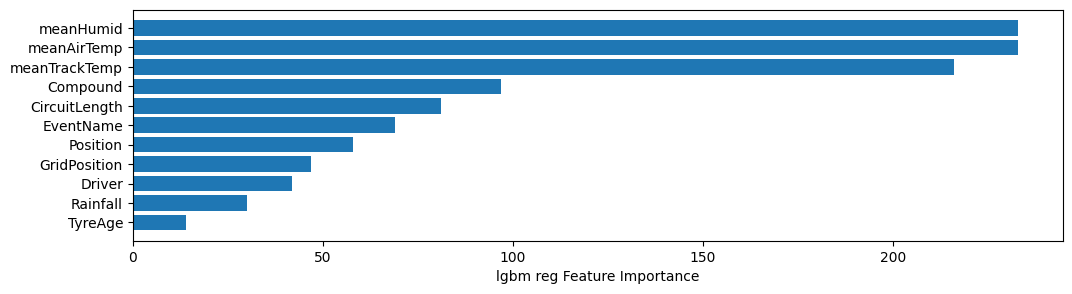

In [58]:
# The closer the feature importance is to 0, the less significance it has to the model.
gbm.feature_importances_
sorted_idx = gbm.feature_importances_.argsort()
sortedFeaNames = [gbm.feature_name_[x] for x in sorted_idx]
fig = plt.figure(figsize=(12,3))
plt.barh(sortedFeaNames, gbm.feature_importances_[sorted_idx])
plt.xlabel("lgbm reg Feature Importance")
plt.show()

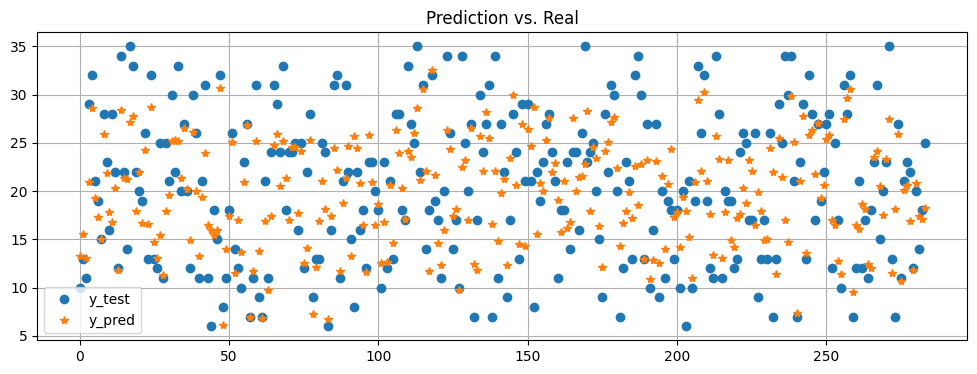

In [59]:
## Prediction vs Real plot

plt.figure(figsize=(12,4) )
plt.plot(range(len(y_pred)),y_test_reg,'o')
plt.plot(range(len(y_pred)),y_pred,'*')
plt.legend(['y_test','y_pred'])
plt.grid()
plt.title('Prediction vs. Real')

plt.show()

Cumulative of density [#Laps, Cumulative-error] provides total error up to a lap.
For example, 80% of predicted errors are in the range of +-5  laps

Let's have a look at how far off predictions are. This is what test residuals will show.

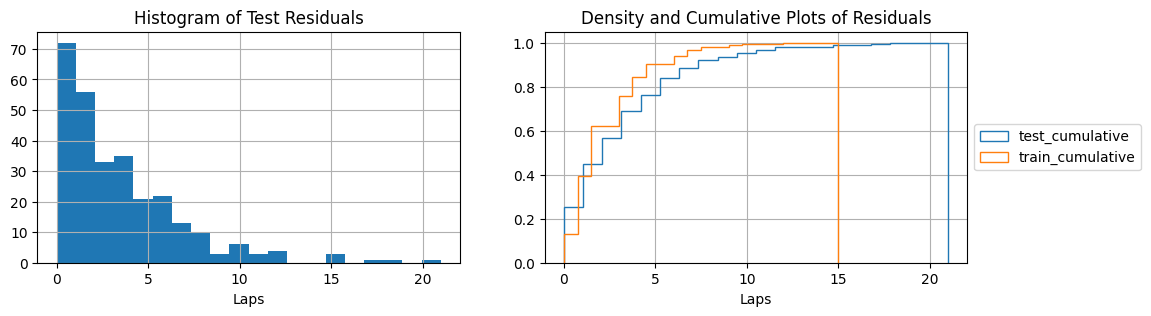

In [60]:
## round y_pred to a closest int number: We want to calculate modeling error in Laps
resid_test = np.abs(np.round(y_pred) - y_test_reg)
resid_train = np.abs(np.round(x_pred) - y_train_reg)
nbins = 20
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].hist(resid_test,bins=nbins)
axs[0].title.set_text('Histogram of Test Residuals')
axs[0].set_xlabel('Laps')
axs[0].grid()

# axs[1].hist(resid_test, density=True, histtype='step',bins =nbins)
axs[1].hist(resid_test, density=True, cumulative=True, histtype='step',bins =nbins)
# axs[1].hist(resid_train, density=True, histtype='step',bins =nbins)
axs[1].hist(resid_train, density=True, cumulative=True, histtype='step',bins =nbins)
axs[1].legend(['test_cumulative','train_cumulative',],
             loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
axs[1].title.set_text('Density and Cumulative Plots of Residuals')
axs[1].set_xlabel('Laps')
plt.show()

The above left figure shows the absolute value of residuals. Looking at this, we can observe the amount of errors in each prediction. We see that the figure is very skewed towards the left, which means that most errors are constrained in the range of [0, 5] laps from the true value, and a big part of all these errors in the [0.0, 2.5] range, which means that our model, even though it makes errors, makes relatively "close" errors to reality.

In the above right picture, we have another way to visualize this in percentages: we can see how many % of errors are accumulated in a specific range, e.g. if we look at the '5.0' value in the *x* axis, we see that 80% of **all** errors are within this range ([0, 5]); and 60% of all errors are within the range of (0, 2.5), which means that most errors from the model aren't that far apart from true values. This allows us to conclude that our model is accurate, and this measurement can complement the baseline accuracy of the model (several Data Science problems focus only on baseline model accuracy without looking at residuals).

In [61]:
X_train_reg.head(5)

,EventName,Compound,Driver,TyreAge,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,Position,CircuitLength
72,1,6,16,4.0,23.961905,37.466667,35.266667,0.0,5.0,17.0,5.303
693,17,4,21,1.0,21.484211,32.094737,57.621053,0.0,17.0,8.0,5.807
976,26,3,12,1.0,20.332258,41.083871,56.248387,0.0,17.0,18.0,4.655
321,6,4,16,4.0,21.096296,47.874074,60.029630,0.0,9.0,11.0,4.309
1012,27,3,31,1.0,26.818519,53.337037,32.233333,0.0,14.0,12.0,4.574


In [62]:
sample = np.array([[1,4,16,3.0,27.961905,37.466667,35.266667,0.0,5.0,17.0,5.303]])
predicted_value = gbm.predict(sample,num_iteration=gbm.best_iteration_)[0]

print(f'Predicted value: {predicted_value}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Predicted value: 17.25567306805649


<font size="5">**Multiclass Modeling**</font>

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import get_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

In [64]:
%%time
model_accuracy = pd.DataFrame()
model_rocs = pd.DataFrame(columns=['Model'])


models = {
  "LGBM" : LGBMClassifier(max_depth=3,
                          n_estimators=100,
                          learning_rate=0.01),
  'XGB' : XGBClassifier(max_depth=3,
                        n_estimators=100,
                        learning_rate= 0.01)
}

# For each model, fit, predict, and get precision, recall, f1-score.
for test, clf in models.items():
    clf.fit(X_train_mc, y_train_mc)
    y_pred = clf.predict(X_test_mc)
    acc = accuracy_score(y_test_mc,y_pred)
    train_pred = clf.predict(X_train_mc)
    train_acc = accuracy_score(y_train_mc, train_pred)
    print("\n", test + ' scores')
    print(acc)
    print(classification_report(y_test_mc,y_pred))
    print(confusion_matrix(y_test_mc,y_pred))
    
    precision, recall, fscore, support = score(y_test_mc, y_pred)
    new_row = pd.DataFrame({
    'Model': [test], 
    'Test_Accuracy': [acc], 
    'Train_acc': [train_acc],
    'precision': [precision],
    'recall': [recall],
    'fscore': [fscore]
    })
    model_accuracy = pd.concat([model_accuracy, new_row], ignore_index=True)

    
    # model_accuracy = model_accuracy.append({'Model': test, 'Test_Accuracy': acc, 'Train_acc': train_acc,
    #                                         'precision': precision,
    #                                         'recall': recall,
    #                                         'fscore': fscore,
    #                                        }, ignore_index=True)

    print('-' * 100,"\n")
res1 = pd.melt(model_accuracy, id_vars=['Model','Test_Accuracy','Train_acc'], value_vars=['precision', 'recall', 'fscore'])
cols = ['class_'+str(x) for x in clf.classes_]
res= pd.concat([res1, pd.DataFrame(res1['value'].tolist(), columns=cols)] ,axis=1).drop('value',axis=1).sort_values(['Model','variable'])
res

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 937
[LightGBM] [Info] Number of data points in the train set: 850, number of used features: 11
[LightGBM] [Info] Start training from score -1.754804
[LightGBM] [Info] Start training from score -1.563453
[LightGBM] [Info] Start training from score -1.817983
[LightGBM] [Info] Start training from score -1.663832
[LightGBM] [Info] Start training from score -1.727957
[LightGBM] [Info] Start training from score -2.427748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

,Model,Test_Accuracy,Train_acc,variable,class_0,class_1,class_2,class_3,class_4,class_5
4,LGBM,0.390845,0.565882,fscore,0.432432,0.489510,0.396040,0.370968,0.344828,0.102564
0,LGBM,0.390845,0.565882,precision,0.355556,0.406977,0.416667,0.383333,0.357143,0.666667
2,LGBM,0.390845,0.565882,recall,0.551724,0.614035,0.377358,0.359375,0.333333,0.055556
5,XGB,0.411972,0.552941,fscore,0.472222,0.474820,0.416667,0.425197,0.314607,0.266667
1,XGB,0.411972,0.552941,precision,0.395349,0.402439,0.465116,0.428571,0.318182,0.666667
3,XGB,0.411972,0.552941,recall,0.586207,0.578947,0.377358,0.421875,0.311111,0.166667


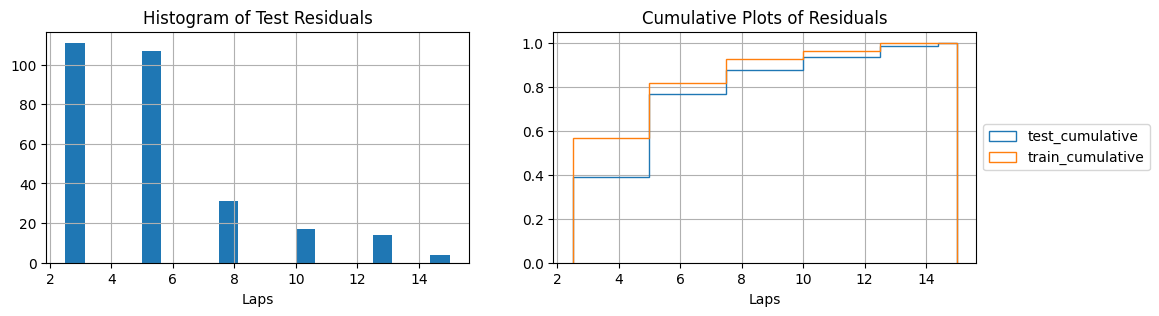

In [65]:
### multiclass model errors
x_pred = models['LGBM'].predict(X_train_mc)
y_pred = models['LGBM'].predict(X_test_mc)

resid_test_mc = (np.abs(y_pred- y_test_mc.astype('category').cat.codes)+1) *2.5
resid_train_mc = (np.abs(x_pred- y_train_mc.astype('category').cat.codes)+1)*2.5
nbins = 20
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].hist(resid_test_mc,bins=nbins)
axs[0].title.set_text('Histogram of Test Residuals')
axs[0].set_xlabel('Laps')
axs[0].grid()

axs[1].hist(resid_test_mc, density=True, cumulative=True, histtype='step',bins =nbins)
axs[1].hist(resid_train_mc, density=True, cumulative=True, histtype='step',bins =nbins)
axs[1].legend(['test_cumulative','train_cumulative',],
             loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
axs[1].title.set_text('Cumulative Plots of Residuals')
axs[1].set_xlabel('Laps')
plt.show()